In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import interact
import scipy.optimize as opt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LassoCV, Lasso


## Data upload
After uploading the data from the 'bikes.csv' file containing the number of rented bicycles depending on date and weather conditions, we will parse it to Pandas DataFrame structure for easier analysis. The funtion head() returns the first five rows of the DataFrame, convenient for inspecting how the data looks. info() tells us we are working with 17379 entries of data and gives all the stored data types. 

In [2]:
da=pd.read_csv('bikes.csv')
df=pd.DataFrame(da)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB
None


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


dropna() function clears the dataframe from all columns or rows that contain an empty value. After using it, no rows were dropped, meaning the uploaded dataframe has no missing values.

In [3]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.4+ MB


## Exploring the data
From the data characteristics sheet, as well as from the given dataframe, we can see that there exists several continuous variables and several discrete. The last three columns represent the dependant variables, how many bicycles were rented to non-registered and registered users at a given hour of a day, and a total score of rented bicycles. Our goal is to explore these dependancies to variables and select those that can contribute most to future predictions of rent numbers.

For simplicity, while exploring data we will focus on the total number of rented bicycles - *cnt*.

We start by inspecting the rent heights relative to the date.

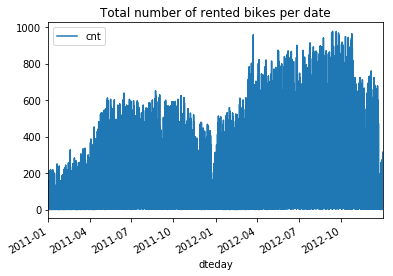

In [4]:
df['dteday'] = pd.to_datetime(df['dteday']) 
df.plot(x='dteday',y='cnt', title='Total number of rented bikes per date')

These are the numbers of total rented bicycles for *both* years of data collection. A similar pattern between two years can immediately be spotted. Since we're interested in how the rent is distributed throughout the year, we will split the data in two plots. 

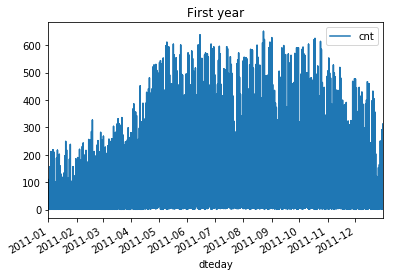

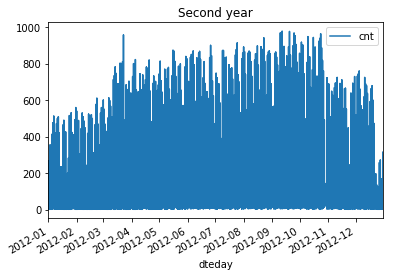

In [5]:
df.loc[(df['yr'] == 0)].plot(x='dteday',y='cnt',title='First year')
df.loc[(df['yr'] == 1)].plot(x='dteday',y='cnt',title='Second year')

The same trend can be visualized using rents per month:

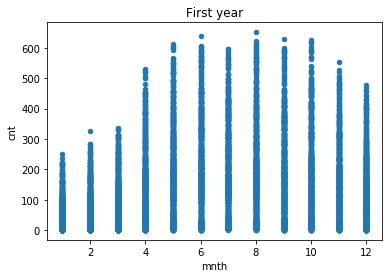

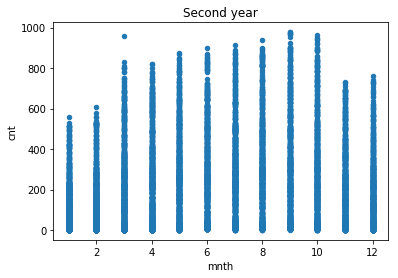

In [6]:
df.loc[(df['yr'] == 0)].plot(x='mnth',y='cnt',title='First year', kind='scatter')
df.loc[(df['yr'] == 1)].plot(x='mnth',y='cnt',title='Second year', kind='scatter')

Fitting a curve using matplotlib reveals a parabolic trend of rents distributed around the center of the year, here given on example of firts year:

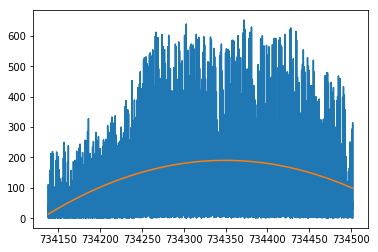

In [7]:
def func(x, a, b, c,d):
     return a*x**3 + b*x**2 + c*x + d

#Plot of the total count relative to days passed from 01-01-2001 (a function can not be fitted to a datetime object) 
plt.plot(df.loc[(df['yr'] == 0)]['dteday'].apply(lambda x:x.toordinal()), df.loc[(df['yr'] == 0)]['cnt'])

#Finding the optimal curve fit and adding it to the plot
parametri, kovar = opt.curve_fit(func, df.loc[(df['yr'] == 0)]['dteday'].apply(lambda x:x.toordinal()), df.loc[(df['yr'] == 0)]['cnt'])

plt.plot(df.loc[(df['yr'] == 0)]['dteday'].apply(lambda x:x.toordinal()), func(df.loc[(df['yr'] == 0)]['dteday'].apply(lambda x:x.toordinal()), *parametri))

#If necessary, parameters of the fit function can be seen by printing the variable parametri

Working with linear functions is less complex. Parabolic shapes can be approximated to linear functions for *cyclic* variables only. Since months of a year are indeed cyclic, it can be expressed as a linear function of two side slopes of the parabola. Parabola given above has a maximum in the middle of the year (summer) and has lower value the more distant the date is from the center of the year i.e. rents are lower both in the direction of December and January. 
We will build a new Series object i.e. a new column for the Dataframe where dates are expressed by number of days until/passed from the center of the year. Center of the year in the Gregorian calendar is July second, as there are 182 days before it and 182 days after it in a year. Therefore, the Series will have values in the range from 0 to 182. 

In [8]:
#Searching for the first row that has the date of interest for two different years
july2011=df[df['dteday']=='2011-07-02'] 
july2012=df[df['dteday']=='2012-07-02']
index11=(july2011.iloc[0]['instant'])-1
index12=(july2012.iloc[0]['instant'])-1

#Splitting date column in two years
year1series=df.loc[(df['yr'] == 0)]['dteday']
year2series=df.loc[(df['yr'] == 1)]['dteday']

#Difference in days from the central day for each row, 
#absolute values are needed since timedelta objects give negative days if the subtrahend is a later date
x=abs(year1series-year1series[index11]).dt.days
y=abs(year2series-year2series[index12]).dt.days

#Combining the series to a common column again
x=x.append(y)

#Appending the new column to the dataframe and visualizing the first five rows
df['days_cntr_yr'] = x
df.head()


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,days_cntr_yr
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,182
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,182
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,182
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,182
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,182


As expected, the beginning of the year is 182 days away from its center. Plotting the new variable to the total count gives:

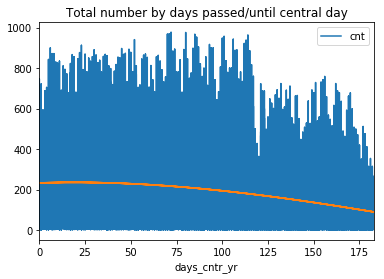

In [9]:
df.plot(x='days_cntr_yr', y='cnt', title = 'Total number by days passed/until central day')

parametri, kovar = opt.curve_fit(func, df['days_cntr_yr'], df['cnt'])
plt.plot(df['days_cntr_yr'], func(df['days_cntr_yr'], *parametri), label="fit")


We can see the best fitted function is still parabolic in nature, but by building this column we can approximate it to a linear function with less error as it has a significantly lower curvature. Linear fit can be made by overriding the shape of the fit function:

Linear fit function: f(x)=-0.8178210874546203x + 263.874971469822


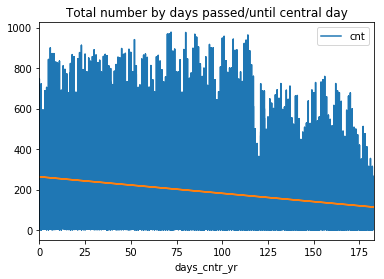

In [10]:
#Searching specifically for the parameters of a liner fit function
def linfunc(x, a, b):
     return a*x + b
    
#Fitting to the same data
df.plot(x='days_cntr_yr', y='cnt', title = 'Total number by days passed/until central day')
parametri, kovar = opt.curve_fit(linfunc, df['days_cntr_yr'], df['cnt'])
plt.plot(df['days_cntr_yr'], linfunc(df['days_cntr_yr'], *parametri), label="fit")


print('Linear fit function: f(x)={}x + {}'.format(parametri[0], parametri[1]))
#This is printed just for completeness as
#we are not interested in particular parameters of these functions e.g. offsets, slopes etc.
#but rather just their nature (linear or polynomial)

Now, if needed, we can use this new variable for the sake of simplicity as a lot of models work better and faster with linear functions. 

Inspecting other columns it can be seen that the total number of rented bicycles is higher during the working days i.e. when it is *not* a holiday or the weekend. Importance of this features will be expanded on later. 

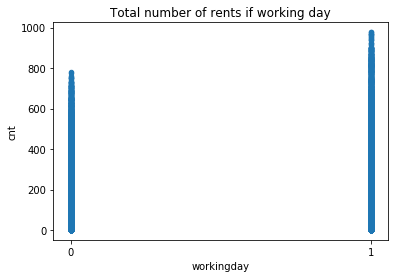

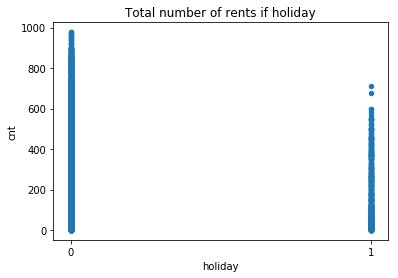

In [11]:
df.plot(x='workingday', y='cnt', title = 'Total number of rents if working day', kind='scatter', xticks=[0,1])
df.plot(x='holiday', y='cnt', title = 'Total number of rents if holiday', kind='scatter', xticks=[0,1])



Using the same approach, we can visualize usage per hour, season and weekday.

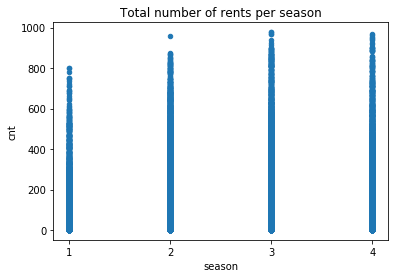

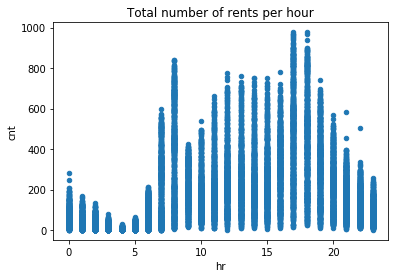

In [12]:
df.plot(x='season', y='cnt', title = 'Total number of rents per season', kind='scatter', xticks=[1,2,3,4])
df.plot(x='hr', y='cnt', title = 'Total number of rents per hour', kind='scatter')



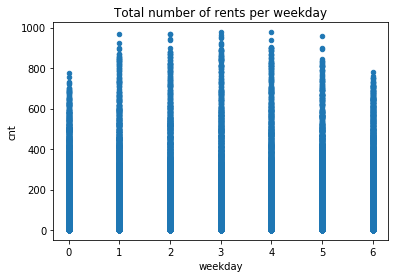

In [13]:
df.plot(x='weekday', y='cnt', title = 'Total number of rents per weekday', kind='scatter')

Maximum values of rents per hour are distributed around the afternoon. Hours are again a cyclic variable and can get reshaped in a similar manner like dates. 

The distribution per weekday resembles that of distribution per date, but we will not be using the same method (distance from central value) for these variables. This is because weekday is in fact a categorical value, it defines which day of the week it is. If fed to a machine learning model, the model can give higher weight to Friday than Tuesday, since their values are 4 and 1 respectively, or can assume higher similarity between Friday and Thursday than Friday and Monday since their numbers are closer, whereas in reality categories (e.g. different days) dont have different importance among themselves if they're not ordinal in nature. Also, some models work only with binary data. For this reason we demonstrate reshaping our data. Since we already showed how to express cyclic data we won't be using it again for *hr* but rather cast it to binary. 

#### Creating dummy variables
Categorical values can be shaped to a vector with n binary values, where n is the number of unique items in the categorical dataset. For example, instead of using integers from 0 to 6 for weekdays, we can assign 7 new columns for every day. In each particular row, we mark the appropriate column with 1 (e.g. ' Monday') and fill the other six with zeros. These variables are usually called dummy variables. We will build them for each categorical value from the dataframe. 

Different months should have some particular pattern of rents, since they belong to different seasons and therefore have different weather conditions which affect bicycle riding. However, if we are interested in this distribution we can still inspect it using the dates of the data by applying conditions to months. Therefore, we will cast seasons and months to dummy variables too. 

All of this will be stored in a new dataframe, because later we will need numerical values from the first dataframe to inspect correlations.

In [14]:
def getdummies(column, prefiks, datafr):
    datafr[column] = pd.Categorical(datafr[column]) #casting to categorical type
    dfdummy = pd.get_dummies(df[column], prefix = prefiks)
    return dfdummy

#We will work with a deep copy
dfc=df.copy()
#Building dataframes of dummy variables for each categorical data
dfdummyweekday=getdummies('weekday','Day', dfc)
dfdummyweather=getdummies('weathersit','Weather', dfc)
dfdummyweather.columns=['Weather_Sunny','Weather_Cloudy','Weather_Rainy/Snowy','Weather_Showers'] #renaming column names
dfdummymonth=getdummies('mnth', 'Month', dfc)
dfdummyhour=getdummies('hr', 'Hour', dfc)
dfdummyyear=getdummies('yr', 'Year', dfc)
dfdummyyear.columns=['first_year','second_year']
dfdummyseason=getdummies('season', 'Season', dfc)
dfdummyseason.columns=['spring','summer', 'autumn', 'winter']

#Checking if the shape has all 17379 rows and the right number of columns
print(dfdummyweekday.shape)
dfdummyseason.head()

(17379, 7)


,spring,summer,autumn,winter
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [15]:
dummydf = pd.concat([dfdummyweekday, dfdummyweather, dfdummymonth, dfdummyhour, dfdummyyear, dfdummyseason], axis=1, sort=False)
dummydf.head()

,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Weather_Sunny,Weather_Cloudy,Weather_Rainy/Snowy,...,Hour_20,Hour_21,Hour_22,Hour_23,first_year,second_year,spring,summer,autumn,winter
0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0
1,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0
2,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0
3,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0
4,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0


Assigning binary variables to categories, called one hot encoding, gave us additional 53 features. After joining it to the original dataframe, we can drop old columns of categorical data. The rest of the variables are continuous and need a different approach. We are keeping the date variable in sake of completeness. The variable *instant* has no meaning for rent numbers as it is just the serial number of record. We will permanently drop this column, but we can access these values with (index+1) if needed.

In [16]:
df.drop(['instant'], axis=1, inplace=True)
absdf=pd.concat([df, dummydf], axis=1, sort=False)

absdf=absdf.drop(['season', 'yr', 'mnth', 'weekday', 'weathersit', 'hr'], axis=1)
absdf.tail()

,dteday,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,Hour_20,Hour_21,Hour_22,Hour_23,first_year,second_year,spring,summer,autumn,winter
17374,2012-12-31,0,1,0.26,0.2576,0.60,0.1642,11,108,119,...,0,0,0,0,0,1,1,0,0,0
17375,2012-12-31,0,1,0.26,0.2576,0.60,0.1642,8,81,89,...,1,0,0,0,0,1,1,0,0,0
17376,2012-12-31,0,1,0.26,0.2576,0.60,0.1642,7,83,90,...,0,1,0,0,0,1,1,0,0,0
17377,2012-12-31,0,1,0.26,0.2727,0.56,0.1343,13,48,61,...,0,0,1,0,0,1,1,0,0,0
17378,2012-12-31,0,1,0.26,0.2727,0.65,0.1343,12,37,49,...,0,0,0,1,0,1,1,0,0,0


#### Continuous variables
In the dataframe, there are four continuous variables, regarding outdoor conditions. These variables are already normalized by their range. To get a sense of their distribution, we will plot them this time for each of the three dependant variable. 

_Note: For space saving, 4x3 distributions are displayed in the same window. Use the dropdown menu 'Condition' to choose the continuous variable, and dropdown menu 'Counts' for different types of rent counts._

In [17]:
def plotter(Condition,Counts):
    df.plot(x=Condition,y=Counts, kind='scatter', color='green')
    
continuousvardict={'Feeling temperature':'atemp', 'Temperature':'temp','Windspeed':'windspeed', 'Humidity':'hum'}
dependantvar={'Total users':'cnt', 'Non-registered users':'casual', 'Registered users':'registered'}
interact(plotter,Condition=continuousvardict, Counts=dependantvar)



interactive(children=(Dropdown(description='Condition', options={'Feeling temperature': 'atemp', 'Temperature'…

<function __main__.plotter(Condition, Counts)>

Visually, three of four variables (temperature, felt temperature and humidity) are distributed around its mean value. This is sensical since people probably tend to use bicycles more when it is not too hot or cold, or too dry or humid. Contrary to that, number of bicycle users reduces with growing wind speed. The registered maximum number of total users is on wind speed of exactly 0. 

In [18]:
df.groupby('windspeed')['cnt'].sum().head()

windspeed
0.0000    350203
0.0896    213804
0.1045    268821
0.1343    306423
0.1642    332998
Name: cnt, dtype: int64

## Correlations
We are interested in importance of different features. First, we can calculate the correlation among continuous and between continuous and dependant variables. 

In [19]:
contincorrel=df[['atemp', 'temp', 'windspeed', 'hum']].corr()
contincorrel.style.background_gradient(cmap='summer').set_precision(3)

,atemp,temp,windspeed,hum
atemp,1,0.988,-0.0623,-0.0519
temp,0.988,1,-0.0231,-0.0699
windspeed,-0.0623,-0.0231,1,-0.29
hum,-0.0519,-0.0699,-0.29,1


As we expected, temperature and feeling temperature are highly correlated, as the latter is a function of the first. Except a small negative correlation between humidity and windspeed, there are no other significant values. Expanding with dependant variables:

In [20]:
contincorrel=df[['atemp', 'temp', 'windspeed', 'hum', 'cnt', 'casual', 'registered']].corr()
contincorrel.style.background_gradient(cmap='winter').set_precision(3)

,atemp,temp,windspeed,hum,cnt,casual,registered
atemp,1,0.988,-0.0623,-0.0519,0.401,0.454,0.333
temp,0.988,1,-0.0231,-0.0699,0.405,0.46,0.335
windspeed,-0.0623,-0.0231,1,-0.29,0.0932,0.0903,0.0823
hum,-0.0519,-0.0699,-0.29,1,-0.323,-0.347,-0.274
cnt,0.401,0.405,0.0932,-0.323,1,0.695,0.972
casual,0.454,0.46,0.0903,-0.347,0.695,1,0.507
registered,0.333,0.335,0.0823,-0.274,0.972,0.507,1


Suprisingly, windspeed has a low correlation with rent numbers for both types of users. High correlation between registered and cnt are due to the fact that registered users contribute more to the number of rents. Casual users have a higher correlation with weather conditions, since people tend to rent bicycles for leisure mostly during pleasant weather. 



In [21]:
df.corr().style.background_gradient(cmap='Oranges').set_precision(3)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,days_cntr_yr
season,1,-0.0107,0.83,-0.00612,-0.00958,-0.00234,0.0137,-0.0145,0.312,0.319,0.151,-0.15,0.12,0.174,0.178,-0.174
yr,-0.0107,1,-0.0105,-0.00387,0.00669,-0.00448,-0.0022,-0.0192,0.0409,0.0392,-0.0835,-0.00874,0.143,0.254,0.25,0.00605
mnth,0.83,-0.0105,1,-0.00577,0.0184,0.0104,-0.00348,0.0054,0.202,0.208,0.164,-0.135,0.0685,0.122,0.121,0.000313
hr,-0.00612,-0.00387,-0.00577,1,0.000479,-0.0035,0.00228,-0.0202,0.138,0.134,-0.276,0.137,0.301,0.374,0.394,0.00612
holiday,-0.00958,0.00669,0.0184,0.000479,1,-0.102,-0.252,-0.017,-0.0273,-0.031,-0.0106,0.00399,0.0316,-0.0473,-0.0309,0.0494
weekday,-0.00234,-0.00448,0.0104,-0.0035,-0.102,1,0.036,0.00331,-0.00179,-0.00882,-0.0372,0.0115,0.0327,0.0216,0.0269,-0.000382
workingday,0.0137,-0.0022,-0.00348,0.00228,-0.252,0.036,1,0.0447,0.0554,0.0547,0.0157,-0.0118,-0.301,0.134,0.0303,-0.0277
weathersit,-0.0145,-0.0192,0.0054,-0.0202,-0.017,0.00331,0.0447,1,-0.103,-0.106,0.418,0.0262,-0.153,-0.121,-0.142,0.0938
temp,0.312,0.0409,0.202,0.138,-0.0273,-0.00179,0.0554,-0.103,1,0.988,-0.0699,-0.0231,0.46,0.335,0.405,-0.835
atemp,0.319,0.0392,0.208,0.134,-0.031,-0.00882,0.0547,-0.106,0.988,1,-0.0519,-0.0623,0.454,0.333,0.401,-0.821


We can explore additional correlations from the old dataframe (before one hot encoding). As seen from the plots, we have a negative correlation between workingday and holiday. Months are highly correlated to the season, as expected. Also, temperature is correlated to the season and therefore also to the month of the year, and slightly to the hour. Temperature has a high correlation with our constructed variable *day_cntr_yr*. This was also expected as the temperature mostly drops the further the days are from the center of summer.

It is interesting to point out that registered users have a negative correlation with holidays and positive with working days, whereas casual users have inversely. Therefore, we can assume that registered users rent bicycles for commute and casual users rent it for leisure on weekends and holidays.

We can see that the total numbers of rented bicycles among casual users don't differ much whether it is a working day or not but numbers are almost three times larger for working days among registered users:

In [22]:
df.groupby('workingday')['casual'].sum()

workingday
0    316732
1    303285
Name: casual, dtype: int64

In [23]:
df.groupby('workingday')['registered'].sum()


workingday
0     683537
1    1989125
Name: registered, dtype: int64

*yr* is showing a significant correlation to *cnt* and *registered*. This can be explained simply by plotting or grouping the total number of rents per year and seeing that the overall popularity is higher in the second year:

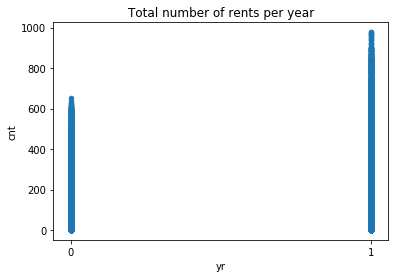

In [24]:
df.groupby('yr')['cnt'].sum()
df.plot(x='yr', y='cnt', title = 'Total number of rents per year', kind='scatter', xticks=[0,1])

## Feature selection
### Correlation based

Now that we presented all the correlations of interest, we can start selecting features based on them. One approach to determining which variables are important for future predictions is by choosing those with highest correlation to the dependant variable. For the beginning, we can extract the Series object from the correlation matrix which contains correlations to all the other variables with the chosen column. We will also sort to the top highly correlated variables:

In [25]:
features_cnt = abs(df.corr()['cnt']) #using absolute values since we are interested in both negative and positive correlations
features_cnt.sort_values(ascending=False,inplace=True)
features_cnt

cnt             1.000000
registered      0.972151
casual          0.694564
temp            0.404772
atemp           0.400929
hr              0.394071
hum             0.322911
yr              0.250495
days_cntr_yr    0.237873
season          0.178056
weathersit      0.142426
mnth            0.120638
windspeed       0.093234
holiday         0.030927
workingday      0.030284
weekday         0.026900
Name: cnt, dtype: float64

In [26]:
features_reg = abs(df.corr()['registered'])
features_reg.sort_values(ascending=False,inplace=True)
features_reg

registered      1.000000
cnt             0.972151
casual          0.506618
hr              0.374141
temp            0.335361
atemp           0.332559
hum             0.273933
yr              0.253684
days_cntr_yr    0.185094
season          0.174226
workingday      0.134326
mnth            0.122273
weathersit      0.120966
windspeed       0.082321
holiday         0.047345
weekday         0.021578
Name: registered, dtype: float64

In [27]:
features_cas = abs(df.corr()['casual'])
features_cas.sort_values(ascending=False,inplace=True)
features_cas

casual          1.000000
cnt             0.694564
registered      0.506618
temp            0.459616
atemp           0.454080
hum             0.347028
days_cntr_yr    0.306904
hr              0.301202
workingday      0.300942
weathersit      0.152628
yr              0.142779
season          0.120206
windspeed       0.090287
mnth            0.068457
weekday         0.032721
holiday         0.031564
Name: casual, dtype: float64

We can choose features directly by interpreting correlations. 

For *cnt*:

*registered* and *casual* are variables with highest correlation to *cnt* but we wont be selecting them for most important features because that would be insensical. The three dependant variables are clearly correlated because *cnt* is a fuction of other two, more specific their sum. We are interested in different conditions that affect rents. The highest correlation belongs to *temp* and this will be our most important feature. *atemp* also has a high correlation, but this is due to its correlation with *temp*. When selecting features, it is also important that our independent variables are uncorrelated among eachother. Since one is a function of the other, it is sufficient to use one of them and therefore we will not select *atemp*. The next six selected features will be *hr, hum, yr, days_cntr_yr, weathersit, windspeed* and *holiday.* It is important to note that even though rents have seen a significant jump in the second year which caused a positive correlation, only two years is not a sufficient amount of data to predict rents for future years. We have dropped *season* and *mnth* due to their high correlation with *days_cntr_yr*.

For *registered*:

With same arguments, we will select *hr, temp, hum, yr, days_cntr_yr, workingday*. We will select *weathersit* for the 7th feature because *mnth* is already expressed through high correlation with *season*. For registered users, the hour of rent is the most significant variable, which supports our assumptions that registered users mostly use bicycles to commute. 


For *casual*:

Selected features for casual users are *temp, hum, days_cntr_yr, hr, workingday, weathersit, yr*. We dropped only the *atemp* from the top correlated variables. Again, significancy of outdoor temperature and a negative correlation with working days further supports our argumentation that casual users rent bicycles for leisure.   

We can automatize this process with a simple ue of lists. Instead of that, we will check our solutions using a built method from sklearn library.

### Recursive Feature Elimination

We can use another approach to select features. Recursive Feature Elimination (or RFE) calculates accuracy of the prediction model (in this case linear regression) and iteratively removes features to select those that negatively affect accuracy the most. To use Linear Regression we first have to split our data into independant variables and targets (*cnt, registered, casual*).

In [28]:
#dataframe of independant variables
dfvar=df.drop(['dteday','cnt','registered','casual'], axis=1)

Targets are just Series that we can easily call from dataframe by their column name. 

For Recursive Feature Elimination we use the rfe class from sklearn and first apply linear regression. We choose 7 as the number of features to select. After transforming the input data we can call *ranking*, which assigns a relevancy score to each feature. We build a Series object with these relevancy scores and sort it by value. Top rows in built Series are now our most important features, and we extract the names of first seven:

In [29]:
def recurfeature(target):
    rfe = RFE(LinearRegression(), 7)
    vartrans = rfe.fit_transform(dfvar,df[target])  
    LinearRegression().fit(vartrans,df[target])
    featuresrank = pd.Series(rfe.ranking_, index = dfvar.columns)
    featuresrank.sort_values(ascending=True,inplace=True)
    return featuresrank
    
feat_cnt=recurfeature('cnt')[:7].index.tolist()
feat_reg=recurfeature('registered')[:7].index.tolist()
feat_cas=recurfeature('casual')[:7].index.tolist()
print('Selected features for cnt: {} \nSelected features for registered: {} \nSelected features for casual: {} '.format(feat_cnt, feat_reg, feat_cas))

Selected features for cnt: ['season', 'yr', 'holiday', 'temp', 'atemp', 'hum', 'windspeed'] 
Selected features for registered: ['season', 'yr', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed'] 
Selected features for casual: ['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed'] 




We can plot these relevancy scores using bultin plot function for Series. Features with *lowest* scores have the highest importance. It is important to notice that even though *season* is first in the list of important features for *cnt* it does not necessarily mean it is more important than *yr*, for example, as they both have a relevancy score of 1.

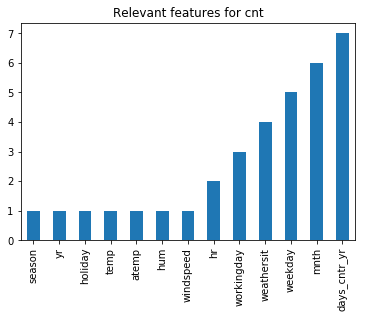

In [30]:
recurfeature('cnt').plot(kind='bar', title='Relevant features for cnt')

Recursive Feature Elimination does not check correlation between different features and for this reason results differ from our previous approach. Before deciding on better approach we can use the same formulation to choose feature with Lasso regularization. 

### Lasso
Least Absolute Shrinkage and Selection Operator (or Lasso) is used for regularization and feature selection through penalization of particular coefficients to lower errors in prediction. Lasso takes into account correlation between variables. Using presented approach: 

In [34]:
def lassofeature(target):
    lasso = LassoCV(cv=5)
    lasso.fit(dfvar,df[target])
    featuresrank = pd.Series(abs(lasso.coef_), index = dfvar.columns)
    featuresrank.sort_values(ascending=False,inplace=True)
    return featuresrank
    

feat_cnt=lassofeature('cnt')[:7].index.tolist()
feat_reg=lassofeature('registered')[:7].index.tolist()
feat_cas=lassofeature('casual')[:7].index.tolist()

print('Final features for dependant variables:')
print('Selected features for cnt: {} \nSelected features for registered: {} \nSelected features for casual: {} '.format(feat_cnt, feat_reg, feat_cas))


Final features for dependant variables:
Selected features for cnt: ['temp', 'hum', 'yr', 'season', 'hr', 'weathersit', 'weekday'] 
Selected features for registered: ['temp', 'hum', 'yr', 'workingday', 'season', 'weathersit', 'hr'] 
Selected features for casual: ['temp', 'hum', 'workingday', 'yr', 'hr', 'season', 'weekday'] 


Since Lasso is more accurate than correlation based selection, takes care of correlation among variables unlike RFE and is a quite popular and simple approach we will be choosing feature selected by it as most significant ones. Therefore, our final results of important features for three dependent variables are printed out above.